**Importeren biblotheken**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
#! pip install -r /Users/PJT/Desktop/DEX_presentatie/requirements.txt

**1. Data inladen**
* van Opendata een .csv-bestand met alle data gedownload van zowel benzine als gas

In [3]:
benzine_file = "C:/Users/PJT/Desktop/DEX_presentatie/DEX_2025_kopie/fuel/3Benzine.csv"
gas_file = "C:/Users/PJT/Desktop/DEX_presentatie/DEX_2025_kopie/fuel/3Gas.csv"

**2. Data opschonen/voorbereiden**
* maken van de csv een dataframe (tabel)

In [4]:
df_benzine = pd.read_csv(benzine_file, delimiter=";", quotechar='"')
df_gas = pd.read_csv(gas_file, delimiter=";", quotechar='"')

df_benzine.columns = ["ID", "Datum", "Benzineprijs"]
df_gas.columns = ["ID", "Datum", "Gasprijs"]

df_benzine["Datum"] = pd.to_datetime(df_benzine["Datum"], format="%Y%m%d")
df_gas["Datum"] = pd.to_datetime(df_gas["Datum"], format="%Y%m%d")

df_benzine.drop(columns=["ID"], inplace=True)
df_gas.drop(columns=["ID"], inplace=True)

# Convert prijzen naar floats
df_benzine["Benzineprijs"] = df_benzine["Benzineprijs"].astype(str).str.strip().str.replace(",", ".").astype(float)
df_gas["Gasprijs"] = df_gas["Gasprijs"].astype(str).str.strip().str.replace(",", ".").astype(float)

# Merge datasets op datum
df = pd.merge(df_benzine, df_gas, on="Datum", how="inner")

print(df.head())
print("---------------------------------------------------------------")
print(df.describe())

       Datum  Benzineprijs  Gasprijs
0 2006-01-01         1.325     0.543
1 2006-01-02         1.328     0.542
2 2006-01-03         1.332     0.540
3 2006-01-04         1.348     0.550
4 2006-01-05         1.347     0.550
---------------------------------------------------------------
                               Datum  Benzineprijs     Gasprijs
count                           6988   6988.000000  6988.000000
mean   2015-07-26 12:00:00.000000256      1.641174     0.675434
min              2006-01-01 00:00:00      1.151000     0.435000
25%              2010-10-13 18:00:00      1.493000     0.588000
50%              2015-07-26 12:00:00      1.622000     0.667000
75%              2020-05-07 06:00:00      1.754000     0.752000
max              2025-02-17 00:00:00      2.383000     1.174000
std                              NaN      0.211144     0.118839


**3. Visualisatie van benzine- en gasprijzen totale dataset**

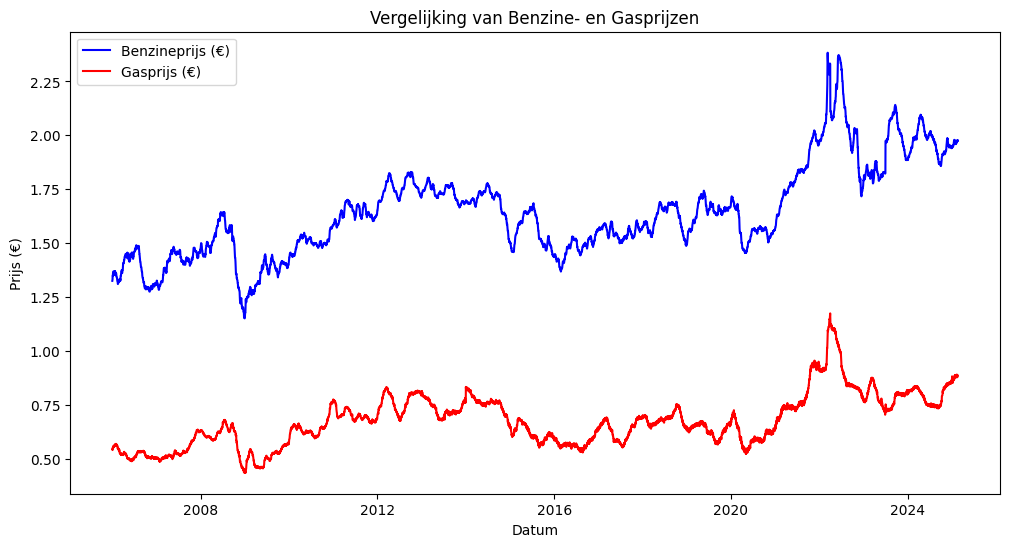

In [5]:
plt.figure(figsize=(12,6))
plt.plot(df["Datum"], df["Benzineprijs"], label="Benzineprijs (€)", color="blue")
plt.plot(df["Datum"], df["Gasprijs"], label="Gasprijs (€)", color="red")
plt.xlabel("Datum")
plt.ylabel("Prijs (€)")
plt.title("Vergelijking van Benzine- en Gasprijzen")
plt.legend()
plt.show()

**4. Train/test split - Verwijder 2021-2025 voor voorspellingen**

In [6]:
df_train = df[df["Datum"] < "2021-01-01"]
df_test = df[df["Datum"] >= "2021-01-01"]

**4. LSTM-model trainen en voorspellen (het algoritme)**

mini neuraal netwerk (Long Short-Term Memory) = goed in voorspellen van patronen in data die in de tijd veranderen

* Invoegen data
* Model bouwen
* Model trainen

In [7]:
window_size = 730 # aantal dagen dat het model data gaat gebruiken= tijdstappen

def create_sequences(data, window_size):
    sequences, labels = [], []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size])
        labels.append(data[i+window_size])
    return np.array(sequences), np.array(labels)

# Voeg inputdata voor model toe
price_series_benzine = df_train["Benzineprijs"].values.reshape(-1, 1)
X_benzine, y_benzine = create_sequences(price_series_benzine, window_size)

price_series_gas = df_train["Gasprijs"].values.reshape(-1, 1)
X_gas, y_gas = create_sequences(price_series_gas, window_size)

# Bouw LSTM-model
def build_lstm_model():
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(window_size, 1)),
        LSTM(50, return_sequences=False),
        Dense(25, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

# Train modellen
model_lstm_benzine = build_lstm_model()
model_lstm_benzine.fit(X_benzine, y_benzine, epochs=20, batch_size=32, verbose=1)

model_lstm_gas = build_lstm_model()
model_lstm_gas.fit(X_gas, y_gas, epochs=20, batch_size=32, verbose=1)

C:\Users\PJT\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 70s 442ms/step - loss: 0.2172
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 87s 582ms/step - loss: 0.0020
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 70s 467ms/step - loss: 3.4497e-04
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 68s 459ms/step - loss: 3.2769e-04
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 69s 466ms/step - loss: 3.2502e-04
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 69s 464ms/step - loss: 3.0211e-04
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 70s 468ms/step - loss: 3.2937e-04
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 72s 482ms/step - loss: 2.8907e-04
Epoch 9/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 73s 492ms/step - loss: 2.6242e-04
Epoch 10/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 70s 466ms/step - loss: 3.5126e-04
Epoch 11/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 68s 458ms/step - loss: 2.6632e-04
Epoch 12/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 66s 445ms/step - loss: 2.4630e-04
Epoch 13/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 71s 480ms/step - loss: 2.4094e-04
Epoch 14/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 6

**5. Voorspellingen genereren voor 2021-2025**

In [8]:
future_months = 12 * 5  # 5 jaar vooruit
future_steps = future_months

future_steps = future_months
tf.get_logger().setLevel('ERROR')

def predict_future(model, last_window, steps):
    predictions = []
    current_window = last_window.copy()
    
    for _ in range(steps):
        with tf.device('/CPU:0'):
            prediction = model.predict(current_window.reshape(1, window_size, 1), verbose=0)[0][0]
        
        predictions.append(prediction)
        current_window = np.append(current_window[1:], prediction).reshape(window_size, 1)
    
    return np.array(predictions)

last_window_benzine = price_series_benzine[-window_size:]
last_window_gas = price_series_gas[-window_size:]

future_benzine = predict_future(model_lstm_benzine, last_window_benzine, future_steps)
future_gas = predict_future(model_lstm_gas, last_window_gas, future_steps)

**6. Voorspellingen opslaan en visualiseren**

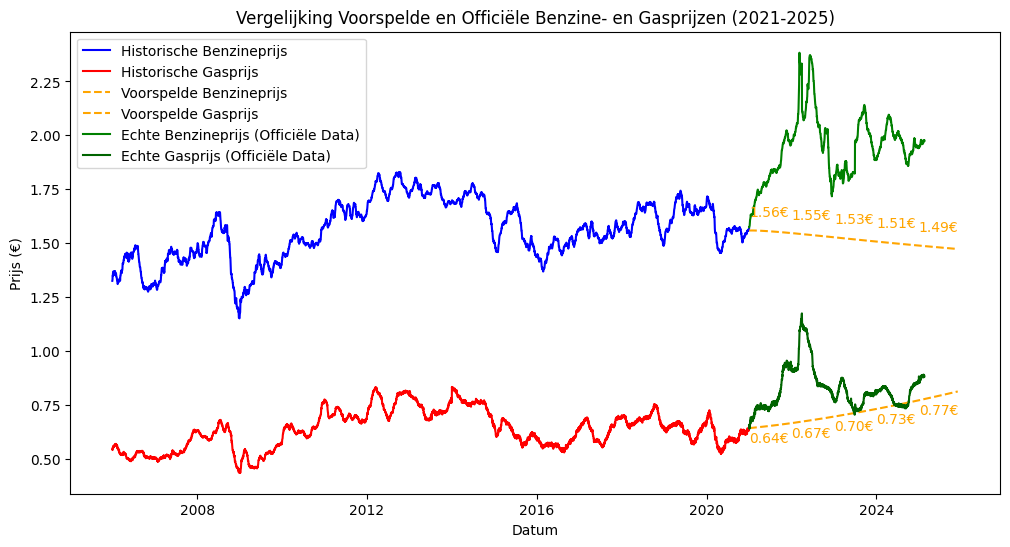

In [9]:
start_date = pd.to_datetime("2021-01-01")
future_dates = pd.date_range(start=start_date, periods=future_steps, freq='MS')

future_df = pd.DataFrame({
    "Datum": future_dates,
    "Voorspelde Benzineprijs (€)": future_benzine,
    "Voorspelde Gasprijs (€)": future_gas
})
future_df.set_index("Datum", inplace=True)

plt.figure(figsize=(12,6))

plt.plot(df_train["Datum"], df_train["Benzineprijs"], label="Historische Benzineprijs", color="blue")
plt.plot(df_train["Datum"], df_train["Gasprijs"], label="Historische Gasprijs", color="red")

plt.plot(future_df.index, future_df["Voorspelde Benzineprijs (€)"], label="Voorspelde Benzineprijs", color="orange", linestyle="dashed")
plt.plot(future_df.index, future_df["Voorspelde Gasprijs (€)"], label="Voorspelde Gasprijs", color="orange", linestyle="dashed")

plt.plot(df_test["Datum"], df_test["Benzineprijs"], label="Echte Benzineprijs (Officiële Data)", color="green", linestyle="solid")
plt.plot(df_test["Datum"], df_test["Gasprijs"], label="Echte Gasprijs (Officiële Data)", color="darkgreen", linestyle="solid")

for year in range(2021, 2026):
    if year in future_df.index.year:
        year_data = future_df.loc[future_df.index.year == year]
        first_entry = year_data.iloc[0]  # Eerste waarde van dat jaar
        
        # Benzineprijs-label met extra padding omhoog
        plt.text(first_entry.name, first_entry["Voorspelde Benzineprijs (€)"] + 0.05, 
                 f"{first_entry['Voorspelde Benzineprijs (€)']:.2f}€", 
                 verticalalignment='bottom', color="orange", fontsize=10)
        
        # Gasprijs-label met extra padding omhoog
        plt.text(first_entry.name, first_entry["Voorspelde Gasprijs (€)"] - 0.08, 
                 f"{first_entry['Voorspelde Gasprijs (€)']:.2f}€", 
                 verticalalignment='bottom', color="orange", fontsize=10)

plt.xlabel("Datum")
plt.ylabel("Prijs (€)")
plt.title("Vergelijking Voorspelde en Officiële Benzine- en Gasprijzen (2021-2025)")
plt.legend()
plt.show()
